In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('background.csv')

/var/folders/7m/k9zp60yn3yd0cp7ksph6wwhw0000gn/T/ipykernel_58974/3855150197.py:1: DtypeWarning: Columns (5168,5272,5328,5329,5340,5341,5351,5470,5479,5661,5663,5685,5695,5696,5706,5764,5772,5788,5803,5815,5816,5828,5900,5901,5937,5946,5965,5966,9287,12349,12353,12356) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('background.csv')


In [3]:
print(f"Number of rows: {len(df)}, Number of columns: {len(df.iloc[0])}")

Number of rows: 4242, Number of columns: 13027


In [4]:
def get_numerical(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    newdf = df.select_dtypes(include=numerics)
    return newdf

In [5]:
df_numerical = get_numerical(df)

In [6]:
len(df_numerical.iloc[0])

12911

In [7]:
constantVariables = pd.read_csv('constantVariables.txt',header=None, index_col=0)

In [8]:
train = pd.read_csv('train.csv', sep=',', header=0, index_col=0)

In [9]:
# Drop constant columns
df= df.drop(constantVariables.index.values, axis = 1)

In [10]:
# Lets remove all columns with more than 70% NAs
mask = (df.isna().sum(axis=0)/len(df)<0.7)
df = df[mask[mask].index]
df.head()

,challengeID,cf1lenhr,cf1lenmin,cf1fint,cf1citsm,f1citywt,f1a2,f1a3,f1a4,f1a4a,...,m4d9,m4e23,f4d6,f4d7,f4d9,m5c6,m5d20,m5k10,f5c6,k5f1
0,1,-9,-9,0,-9,-3.000000,-9,-9,-9,-9,...,6.269946,5.180325,2.511131,1.718804,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
1,2,0,40,1,1,68.455658,2,1,1,-6,...,6.269946,27.680196,2.511131,1.718804,6.473537,16.369411,26.671897,9.628369,15.981275,3.667679
2,3,0,45,1,1,42.319057,1,1,1,-6,...,6.269946,5.180325,20.867881,24.115867,6.473537,16.369411,4.476881,9.628369,15.981275,24.038266
3,4,0,45,1,1,25.628830,1,1,1,-6,...,6.269946,5.180325,22.018875,22.932641,6.473537,-5.169243,4.476881,9.628369,-6.303171,4.140511
4,5,-6,50,1,1,41.954487,2,1,1,-6,...,6.269946,5.180325,22.916602,22.988036,6.473537,-6.034660,4.476881,9.628369,-6.211828,3.668879


In [11]:
train.head(3)

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,3.5,0.090909,0.0,0.0,0.0


In [12]:
X_train, X_CV, y_train, y_CV = train_test_split(df.loc[train.index] , train, test_size=0.33, random_state=42)

In [13]:
X_overall = pd.concat([X_train, X_CV])
y_overall = pd.concat([y_train, y_CV])

In [14]:
print(y_overall.columns)

Index(['gpa', 'grit', 'materialHardship', 'eviction', 'layoff', 'jobTraining'], dtype='object')


In [15]:
for variable in y_overall.columns:
    numerator = len(y_overall[y_overall[variable].isnull()])
    denominator = len(y_overall[y_overall[variable].notnull()])+numerator
    print(f"% null values for {variable} is: {(numerator/denominator)*100} % \n")

% null values for gpa is: 45.07307873644507 % 

% null values for grit is: 33.144743045733144 % 

% null values for materialHardship is: 31.211692597831213 % 

% null values for eviction is: 31.211692597831213 % 

% null values for layoff is: 39.792550683639796 % 

% null values for jobTraining is: 31.117397454031114 % 



In [16]:
y_overall_outliers = y_overall.fillna(0)

In [17]:
def percent_outliers(col):
    Q1 = np.quantile(y_overall_outliers[col],0.25)
    Q3 = np.quantile(y_overall_outliers[col],0.75)
    IQR = Q3-Q1
    outliers = len(y_overall_outliers[(y_overall_outliers[col]> Q3+(1.5*IQR)) | (y_overall_outliers[col]< Q1-(1.5*IQR))])
    print(Q3)
    return outliers/len(y_overall_outliers)*100

In [18]:
percent_outliers('materialHardship')

0.0909090909090909


12.635549269212634

In [19]:
train['eviction'].unique()

array([nan,  0.,  1.])

In [20]:
X_overall.isna().sum().sum()

69276

In [21]:
X_overall.shape

(2121, 10561)

In [22]:
2121*10561

22399881

In [23]:
print(f"{69276/22399881*100}% of the values in X are missing")

0.3092695001370766% of the values in X are missing


In [24]:
len(y_overall)

2121

In [25]:
X_copy = X_overall.copy()

In [26]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_copy_nonnum = X_copy.select_dtypes(exclude=numerics)

In [27]:
X_copy_nonnum.dtypes

cf4fint           object
ch5ppvtae         object
ch5ppvtpr         object
ch5wj9pr          object
ch5wj9ae          object
                   ...  
q5citywt_rep68    object
q5citywt_rep69    object
q5citywt_rep70    object
q5citywt_rep71    object
q5citywt_rep72    object
Length: 81, dtype: object

In [28]:
remove_cols = []
for val,i in enumerate(X_copy_nonnum.iloc[0]):
    if i == 'Other':
        remove_cols.append(X_copy_nonnum.iloc[:,val])
remove_col = []
for i in remove_cols:
    remove_col.append(i.name)

In [29]:
remove_col.append('q5citywt_rep28')
remove_col.append('cf4fint')
remove_col.append('ch5ppvtae')
remove_col.append('ch5wj9ae')
remove_col.append('ch5dsae')
remove_col.append('ch5wj10ae')

In [30]:
X_copy_nonnum = X_copy_nonnum.drop(remove_col, axis=1)

In [31]:
def convert(colname):
    lis = []
    for i in X_copy_nonnum[colname]:
        if i != 'Other' and i != '<0.1':
            lis.append(float(i))
    m = np.mean(lis)
    lis2 = []
    for j in X_copy_nonnum[colname]:
        if j == 'Other' or j == '<0.1':
            lis2.append(m)
        else:
            lis2.append(float(j))
    X_copy_nonnum[colname] = lis2

In [32]:
#X_copy_nonnum[['ch5ppvtpr', 'ch5wj9pr', 'ch5wj10pr']] = X_copy_nonnum.astype('float64')
convert('ch5ppvtpr')
convert('ch5wj9pr')
convert('ch5wj10pr')

In [33]:
X_overall = X_overall.drop(remove_col, axis=1)

In [34]:
X_overall['ch5ppvtpr'] = X_copy_nonnum['ch5ppvtpr']
X_overall['ch5wj9pr'] = X_copy_nonnum['ch5wj9pr']
X_overall['ch5wj10pr'] = X_copy_nonnum['ch5wj10pr']

In [35]:
knn = KNNImputer(n_neighbors=10, add_indicator=True)
knn.fit(X_overall)
X_overall = knn.transform(X_overall)

In [36]:
y_overall[['gpa','grit','materialHardship']]

,gpa,grit,materialHardship
challengeID,,,
1838,3.00,3.50,0.000000
4229,NaN,3.50,0.000000
1771,1.25,3.00,0.090909
1596,NaN,3.75,0.000000
2066,1.75,3.00,0.000000
...,...,...,...
4213,NaN,3.75,0.090909
947,2.75,4.00,0.000000
2342,NaN,NaN,NaN


In [38]:
knn = KNNImputer(n_neighbors=2)
knn.fit(y_overall[['gpa','grit','materialHardship']])
y_overall_continuous = knn.transform(y_overall[['gpa','grit','materialHardship']])

In [40]:
y_overall

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
1838,3.00,3.50,0.000000,0.0,0.0,0.0
4229,NaN,3.50,0.000000,0.0,0.0,0.0
1771,1.25,3.00,0.090909,0.0,NaN,0.0
1596,NaN,3.75,0.000000,0.0,0.0,1.0
2066,1.75,3.00,0.000000,0.0,0.0,1.0
...,...,...,...,...,...,...
4213,NaN,3.75,0.090909,0.0,0.0,0.0
947,2.75,4.00,0.000000,0.0,0.0,0.0
2342,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
y_overall['eviction'] = y_overall['eviction'].fillna(y_overall['eviction'].mode()[0])
y_overall['layoff'] = y_overall['layoff'].fillna(y_overall['layoff'].mode()[0])
y_overall['jobTraining'] = y_overall['jobTraining'].fillna(y_overall['jobTraining'].mode()[0])

In [47]:
y_overall['gpa'] = y_overall_continuous[:,0]
y_overall['grit'] = y_overall_continuous[:,1]
y_overall['materialHardship'] = y_overall_continuous[:,2]

In [50]:
y_overall

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
1838,3.000000,3.500000,0.000000,0.0,0.0,0.0
4229,3.250000,3.500000,0.000000,0.0,0.0,0.0
1771,1.250000,3.000000,0.090909,0.0,0.0,0.0
1596,3.250000,3.750000,0.000000,0.0,0.0,1.0
2066,1.750000,3.000000,0.000000,0.0,0.0,1.0
...,...,...,...,...,...,...
4213,4.000000,3.750000,0.090909,0.0,0.0,0.0
947,2.750000,4.000000,0.000000,0.0,0.0,0.0
2342,2.866738,3.427539,0.103745,0.0,0.0,0.0


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_overall, y_overall, test_size = 0.3, random_state= 123)

In [52]:
y_train.rename(columns={0:'gpa',1:'grit',2:'materialHardship', 3: 'eviction', 4:'layoff', 5:'jobTraining'}, inplace=True)

In [53]:
y_test.rename(columns={0:'gpa',1:'grit',2:'materialHardship', 3: 'eviction', 4:'layoff', 5:'jobTraining'}, inplace=True)

array([[<AxesSubplot:title={'center':'materialHardship'}>,
        <AxesSubplot:title={'center':'gpa'}>],
       [<AxesSubplot:title={'center':'grit'}>, <AxesSubplot:>]],
      dtype=object)

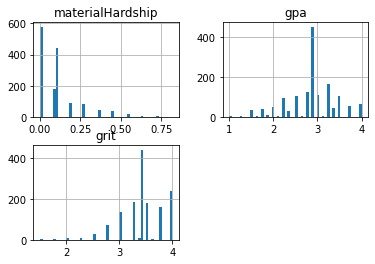

In [54]:
y_train[['materialHardship','gpa','grit']].hist(bins=50)

In [152]:
y_train['layoff']

1723    0.000000
1697    0.209084
1616    0.000000
1890    0.000000
463     0.209084
          ...   
1593    0.000000
1147    1.000000
1766    0.209084
1122    0.000000
1346    0.209084
Name: layoff, Length: 1484, dtype: float64

In [55]:
y_train_gpa = y_train['gpa']
y_train_grit = y_train['grit']
y_train_eviction = y_train['eviction']
y_train_materialHardship = y_train['materialHardship']
y_train_layoff = y_train['layoff']
y_train_jobTraining = y_train['jobTraining']

In [56]:
y_test_gpa = y_test['gpa']
y_test_grit = y_test['grit']
y_test_eviction = y_test['eviction']
y_test_materialHardship = y_test['materialHardship']
y_test_layoff = y_test['layoff']
y_test_jobTraining = y_test['jobTraining']

In [57]:
X_train

array([[ 3.450e+03, -9.000e+00, -9.000e+00, ...,  0.000e+00,  1.000e+00,
         1.000e+00],
       [ 2.196e+03, -3.000e+00,  3.800e+01, ...,  1.000e+00,  1.000e+00,
         1.000e+00],
       [ 2.100e+03, -9.000e+00, -9.000e+00, ...,  1.000e+00,  1.000e+00,
         1.000e+00],
       ...,
       [ 2.136e+03,  0.000e+00,  3.400e+01, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 4.173e+03,  1.000e+00, -3.000e+00, ...,  0.000e+00,  0.000e+00,
         0.000e+00],
       [ 5.620e+02,  0.000e+00,  4.800e+01, ...,  0.000e+00,  1.000e+00,
         0.000e+00]])

In [58]:
normalizer = StandardScaler()
X_train_scaled = normalizer.fit_transform(X_train)

In [45]:
baseline1 = LinearRegression(normalize = False) # Features already standardized so normalize is False
baseline1_params = params = [{'fit_intercept': [True, False] }]
grid = GridSearchCV(baseline1,
                         param_grid=baseline1_params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=5)

In [73]:
from sklearn.linear_model import LogisticRegression
baseline2 = LogisticRegression(penalty= 'none')

In [78]:
baseline2.fit(X_train_scaled, y_train_layoff)

LogisticRegression(penalty='none')

In [79]:
baseline2.score(X_test_scaled, y_test_layoff)

0.7660910518053375

In [81]:
from sklearn.ensemble import RandomForestClassifier
classifier1 = RandomForestClassifier(max_depth=100)

In [86]:
classifier1.fit(X_train_scaled, y_train_eviction)

RandomForestClassifier(max_depth=100)

In [87]:
classifier1.score(X_test_scaled,y_test_eviction)

0.9638932496075353

In [106]:
from sklearn.ensemble import GradientBoostingClassifier
classifier2 = GradientBoostingClassifier(n_estimators=1000, 
max_depth=100, 
learning_rate=0.01, 
subsample=0.5, 
max_features='sqrt', 
loss='deviance', 
random_state=123)

In [107]:
classifier2.fit(X_train_scaled, y_train_layoff)

GradientBoostingClassifier(learning_rate=0.01, max_depth=100,
                           max_features='sqrt', n_estimators=5000,
                           random_state=123, subsample=0.5)

In [108]:
classifier2.score(X_test_scaled,y_test_layoff)

0.8916797488226059

In [73]:
grid.fit(X_train_scaled, np.array(y_train_jobTraining))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END .................................fit_intercept=True; total time=   1.0s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END .................................fit_intercept=True; total time=   0.8s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END .................................fit_intercept=True; total time=   0.8s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END .................................fit_intercept=True; total time=   1.0s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END .................................fit_intercept=True; total time=   1.1s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END ................................fit_intercept=False; total time=   1.0s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END ................................fit_intercept=False; total time=   1.0s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END ................................fit_intercept=False; total time=   1.1s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END ................................fit_intercept=False; total time=   1.2s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


[CV] END ................................fit_intercept=False; total time=   1.0s


/Users/khyatikhandelwal/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


GridSearchCV(cv=5, estimator=LinearRegression(normalize=False), n_jobs=1,
             param_grid=[{'fit_intercept': [True, False]}],
             scoring='neg_mean_squared_error', verbose=2)

In [74]:
abs(grid.best_score_)

0.33106700764470254

In [67]:
normalizer = StandardScaler()
X_test_scaled = normalizer.fit_transform(X_test)

In [76]:
mean_squared_error(y_test_jobTraining, grid.predict(X_test_scaled))

0.3512748718648361

In [77]:
from sklearn.linear_model import Lasso
baseline_2 = Lasso() # Features already standardized so normalize is False
baseline1_params = params = [{'fit_intercept': [True, False] }]
grid_2 = GridSearchCV(baseline_2,
                         param_grid=baseline1_params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=5)

In [88]:
grid_2.fit(X_train_scaled, np.array(y_train_jobTraining))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................................fit_intercept=True; total time=   0.2s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.1s
[CV] END .................................fit_intercept=True; total time=   0.2s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.1s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.1s


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=1,
             param_grid=[{'fit_intercept': [True, False]}],
             scoring='neg_mean_squared_error', verbose=2)

In [89]:
mean_squared_error(y_test_jobTraining, grid_2.predict(X_test_scaled))

0.11718269106346114

In [91]:
from sklearn.linear_model import Ridge
baseline_3 = Ridge() # Features already standardized so normalize is False
baseline1_params = params = [{'fit_intercept': [True, False] }]
grid_3 = GridSearchCV(baseline_3,
                         param_grid=baseline1_params,
                         scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                         n_jobs=1,
                         verbose=2,
                         cv=5)

In [102]:
grid_3.fit(X_train_scaled, np.array(y_train_jobTraining))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................................fit_intercept=True; total time=   0.3s
[CV] END .................................fit_intercept=True; total time=   0.2s
[CV] END .................................fit_intercept=True; total time=   0.2s
[CV] END .................................fit_intercept=True; total time=   0.2s
[CV] END .................................fit_intercept=True; total time=   0.2s
[CV] END ................................fit_intercept=False; total time=   0.2s
[CV] END ................................fit_intercept=False; total time=   0.2s
[CV] END ................................fit_intercept=False; total time=   0.2s
[CV] END ................................fit_intercept=False; total time=   0.2s
[CV] END ................................fit_intercept=False; total time=   0.2s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=1,
             param_grid=[{'fit_intercept': [True, False]}],
             scoring='neg_mean_squared_error', verbose=2)

In [103]:
mean_squared_error(y_test_jobTraining, grid_3.predict(X_test_scaled))

0.3455334950300636

In [141]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
tree1 = RandomForestRegressor(max_depth=100)
tree2 = GradientBoostingRegressor(n_estimators= 200)

In [117]:
tree1.fit(X_train_scaled, np.array(y_train_eviction))

RandomForestRegressor(max_depth=100)

In [118]:
mean_squared_error(y_test_eviction, tree1.predict(X_test_scaled))

0.049481108396726654

In [142]:
tree2.fit(X_train_scaled, np.array(y_train_layoff))

GradientBoostingRegressor(n_estimators=200)

In [144]:
mean_squared_error(y_test_layoff, tree2.predict(X_test_scaled))

0.10826824986231454

In [ ]:
mean_squared_error(y_test_gpa, grid_search.predict(X_test_scaled))